# Character Impact Project (Part 5) - Facial Classifier Comparison
## Facial Detection
### Alden Chico

---

## Premise

I want to preface this blog post with a full disclaimer. I'm working on this project from the comfort of my own apartment running all my code via my 2015 Macbook Pro. I don't have access to cloud computing capabilities via Microsoft Azure or Amazon Web Services to run my code. As such, time and computing power is a limited resource for me.

<a href="https://aldenmchico.github.io/Alden-Blog/character_impact/part_4/facial_detection">In the last blog post</a> we discussed the two main facial detection classifiers that are available in OpenCV: Haar Classifier and Local Binary Pattern Classifier. It would be beneficial for us to find which of these classifiers is more time efficient in classifying faces from a picture since we're going to process many pictures over the course of this project.

To put the number of pictures that we're going to process at the end of the project into perspective, let's do some simple math. There are 6 episodes of the first season of <i>The Office</i>. Each episode runs for around 21 minutes at 30 frames per second. Each frame counts as its own individual picture. 

$$30 \frac{frames}{sec} * 60 \frac{sec}{min} * 21 \frac{min}{episode} * 6 \frac{episodes}{season} = 226800 \frac{frames}{season}$$

<figure>
<img src="https://vignette.wikia.nocookie.net/theoffice/images/d/d9/Michaelklump.jpg/revision/latest?cb=20100327171359" alt="Michael Scott Shocked.jpg" class="center">
<figcaption><center><b>That's a lot of pictures...</b></center></figcaption>
</figure> 

Yes, for the end of this project, we're going to run our facial recognition classifier on around 226,800 frames. Now, you can make the argument that since these episodes don't change, detection accuracy is more important than detection timing. Timing would be more beneficial for a live broadcast, for example, where the time the classifier has to find characters on screen is constrainted by the time it takes to broadcast what's happening live to the television audience. However, I'm still more invested in using the faster classifier since I'll be running my code through multiple design iterations for improvements. The faster facial detection classifier will allow me to tradeoff detection accuracy with recognition accuracy further down into the project.

So for this entry, we're going to take the Haar and LBP facial classifiers and generate a distribution of average classifier runtimes for both classifiers. We'll do this through a process called <b><i>bootstrap sampling</i></b>. Next, we'll combine the two variables as a difference of two averages and perform a Null Hypothesis Test to figure out if there is a measurable difference between the classifiers. And lastly, if there is a difference, we'll select which classifier outperforms the other and use that classifier for the remainder of the project. Let's get started!

---

## An Introduction to Bootstrap Testing

First, before we begin our discussion on Bootstrap testing, let's start by remembering some of our work from the last post. The steps for facial detection are as follows:
    1. Instantiate the facial detection classifier object
    2. Convert the image you want to use into grayscale
    3. Run ```detectMultiScale``` on the image using the classifier object
    4. (Optional) Print a rectangle around the image and the time it took to run and display the results.
That's really are there is to facial detection. Let's see it in action.

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
# 1. Instantiate the facial detection classifier object
haar_face_cascade = cv2.CascadeClassifier("reference/5-Facial_Classifier_Decision/haarcascade_frontalface_default.xml")

In [3]:
# 2. Convert the image you want to use into grayscale
test1 = cv2.imread('reference/5-Facial_Classifier_Decision/test_images/2.jpg')
gray_img = cv2.cvtColor(test1, cv2.COLOR_BGR2GRAY)

In [4]:
# 3. Run ```detectMultiScale``` on the image using the classifier object
start = time.time()
faces = haar_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)
end = time.time()

Face detected in 252.48 ms


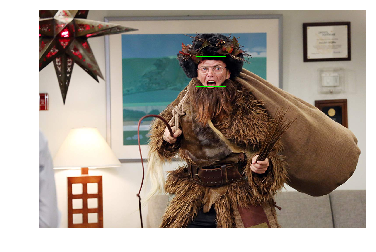

In [5]:
# 4. (Optional) Print a rectangle around the image and time it took to run and display the results.

# Draw a rectangle around where the face cascade found the face
test1_copy = test1.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(test1_copy, (x,y), (x+w, y+h), (0, 255, 0), 2)

# Print the time
detect_time = (end-start)*1000
print('Face detected in {:.2f} ms'.format(detect_time))

# Display the face detected picture
test1_copy = cv2.cvtColor(test1_copy, cv2.COLOR_BGR2RGB)
_ = plt.axis('off')
_ = plt.imshow(test1_copy)

In the above example, we used the Haar classifier on the image of Dwight to find where Dwight's face was in the picture. Now let's use the LBP classifier on the same image and display the results.

Face detected in 117.14 ms


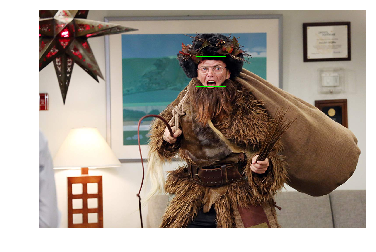

In [6]:
# Instantiate the Haar Face Cascade classifier
lbp_face_cascade = cv2.CascadeClassifier("reference/5-Facial_Classifier_Decision/lbpcascade_frontalface.xml")

# Convert example image from BGR color coding to grayscale
test1 = cv2.imread('reference/5-Facial_Classifier_Decision/test_images/2.jpg')
gray_img = cv2.cvtColor(test1, cv2.COLOR_BGR2GRAY)

# Start the timer
start = time.time()

# Apply the Haar face cascade to find faces in the grayscale image
faces = haar_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)

# End the timer after the face has been detected
end = time.time()

# Draw a rectangle around where the face cascade found the face
test1_copy = test1.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(test1_copy, (x,y), (x+w, y+h), (0, 255, 0), 2)

# Print the time
detect_time = (end-start)*1000
print('Face detected in {:.2f} ms'.format(detect_time))

# Display the face detected picture
test1_copy = cv2.cvtColor(test1_copy, cv2.COLOR_BGR2RGB)
_ = plt.axis('off')
_ = plt.imshow(test1_copy)

In the above examples, you can see that both classifiers were able to detect Dwight's face in the image. The time it took the Haar classifier to complete this task was around 40 ms slower than the time it took the LBP classifier to complete this task. A 130 ms slower runtime on a single image means that the Haar classifier would run around 2 minutes slower for every minute of video versus the LBP classifier.

But of course, not all images will have a 100+ ms runtime. Some images are going to be processed quicker than this and other images may take longer. Because we have a variance in classification time from image to image, we can model the distribution of runtimes over the course of many images.

To start this all off, let's make a function called ```img_detect_times```. In this function, we'll want to accept a list of image file names that we'll want to process as well as the classifier we'll want to use to process the images. At the end of the function, let's return a list of how long it took to process all the images and the average runtime for that batch of images.

In [7]:
def img_detect_times(img_list, classifier):
    
    # Create a list to store all the face detect times
    detect_time_list = []
    for image in img_list:

        # Convert example image from BGR color coding to grayscale
        cv2_img = cv2.imread(image)
        gray_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)

        # Start the timer
        start = time.time()

        # Apply the Haar face cascade to find faces in the grayscale image
        faces = classifier.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)

        # End the timer after the face has been detected
        end = time.time()

        # Print the time
        detect_time = (end-start)*1000

        # Add the face detect time to the list
        detect_time_list.append(detect_time)

    # Find the average face detect time from all the images
    avg_detect_time = np.mean(detect_time_list)
    
    # Return the detect time list and the average detect time
    return detect_time_list, avg_detect_time

So now that we have our ```img_detect_times``` function prepared, let's load all our test images into our program. To do this, the Python ```glob``` function let's us find all path names in the designated file path that follow the given regular expression. For this post, I prepared a batch of 30 test images from <i>The Office</i>. All the images we'll process for classification are held in the ```'reference/5-Facial_Classifier_Decision/test_images/*.jpg'``` path. The \* indicates that we want to retrieve all files in that path where the \* can be filled in with any characters. Here, we'll run the glob function and print out the first 5 image paths that the function returns.

In [8]:
# Load all the jpg file names in the filepath
test_images = glob('reference/5-Facial_Classifier_Decision/test_images/*.jpg')
test_images[0:5]

['reference/5-Facial_Classifier_Decision/test_images/14.jpg',
 'reference/5-Facial_Classifier_Decision/test_images/7.jpg',
 'reference/5-Facial_Classifier_Decision/test_images/8.jpg',
 'reference/5-Facial_Classifier_Decision/test_images/13.jpg',
 'reference/5-Facial_Classifier_Decision/test_images/20.jpg']

All the image file paths are loaded into ```test_images```. What we can do now is run our ```img_detect_times``` function on ```test_images``` to find the average runtime for both classifiers.

In [9]:
# Instantiate the Haar Classifier
haar_face_cascade = cv2.CascadeClassifier("reference/5-Facial_Classifier_Decision/haarcascade_frontalface_default.xml")
detect_time_list, avg_detect_time = img_detect_times(test_images, haar_face_cascade)

# Print all the detect times for the test images using Haar Classifier
for detect_time in detect_time_list[:5]:
    print('Face detected in {:.2f} ms'.format(detect_time))

# Print the average detect time using Haar Classifier
print('Average Detect Time : {:.2f} ms'.format(avg_detect_time))

Face detected in 24.47 ms
Face detected in 21.53 ms
Face detected in 22.47 ms
Face detected in 21.38 ms
Face detected in 17.97 ms
Average Detect Time : 39.31 ms


In [10]:
# Instantiate the LBP Classifier
lbp_face_cascade = cv2.CascadeClassifier("reference/5-Facial_Classifier_Decision/lbpcascade_frontalface.xml")
detect_time_list, avg_detect_time = img_detect_times(test_images, lbp_face_cascade)


# Print all the detect times for the test images using LBP Classifier
for detect_time in detect_time_list[:5]:
    print('Face detected in {:.2f} ms'.format(detect_time))

# Print the average detect time using LBP Classifier
print('Average Detect Time : {:.2f} ms'.format(avg_detect_time))

Face detected in 8.34 ms
Face detected in 8.20 ms
Face detected in 8.64 ms
Face detected in 8.40 ms
Face detected in 8.05 ms
Average Detect Time : 18.95 ms


On this single batch of 30 images, we find that the average runtime for the Haar classifier is around 20 ms slower than the average runtime of the LBP classifier. At this point, we might just say that the Haar classifier is definitively slower than the LBP classifier and call it a day. However, this might just be the case for this single batch of 30 images. We might take another batch of 30 images and find that the opposite is true. 

Well, to test this theory, we could scour the internet for another batch of 30 images, find the average classifier runtime on that batch, and see if the Haar classifier is still slower than the LBP classifier. But then we would only have 2 average run times. According to the Central Limit Theorem, we'll need at least 30 average runtimes to find an approximately normal distribution of average runtimes. And from the normally distributed runtimes, only then can we infer statements comparing the two classifiers. Since each average runtime consists of the runtime of 30 images, that means we'll have to find at least 900 images to test our classifier against!

<figure>
<img src="https://d13ezvd6yrslxm.cloudfront.net/wp/wp-content/images/tomclancy-jimryan-mashup-700x362.jpg" alt="Jim.jpg" class="center">
<figcaption><center><b>Ain't Nobody Got Time for That :/</b></center></figcaption>
</figure> 

Thankfully, we won't have to put in that much effort. Instead, we can employ a process known as <i><b>bootstrapping</b></i>. Bootstrapping is a means of collecting samples of 30 images using the same batch of 30 images that we already have. We do this by randomly choosing 30 images from the batch of 30 images with replacement. This is known as a <i><b>bootstrap sample</b></i>. Then, we run our facial classifier on our bootstrap sample of 30 images to get an average facial detection runtime. The average runtime on our bootstrap sample is known as the <i><b>bootstrap replicate</b></i>. We repeat this process again. Gather a bootstrap sample and find its bootstrap replicate. Repeating this enough times yields an approximately normal distribution that we can use to make inferences about the population.

This process works because we're sampling with replacement. Sampling with replacement means that there's a chance that the same image would get chosen more than once for our bootstrap sample, but that's okay! Choosing the same image twice is like having another image in our sample with the same runtime. It's plausible to believe that since we have an image with that given runtime, there's another image on the internet that we can find that would have a runtime that's really close to that image's runtime. And besides, if we didn't sample with replacement, the average runtimes across all bootstrap samples would be identical.

Now that we're all caught up on the theory behind bootstrapping, let's put it into action. What we're going to do is take a bootstrap sample from the ```test_images``` list and find its average runtime. We'll store the average runtime as either ```haar_bs_replicate``` or ```lbp_bs_replicate```. We'll then append the replicate to a list of replicates and repeat the process 100 times. At the very end, we'll plot the distribution of bootstrap replicates for both the Haar and LBP classifiers.

In [11]:
# Set the random seed so that the same samples will be pulled from both bootstrap tests
np.random.seed(42)

# Generate a list of bootstrap replicate average detection times from Haar Classifier
haar_bs_replicate_list = []
for i in range(100):
    bs_sample = np.random.choice(test_images, len(test_images))
    _, haar_bs_replicate = img_detect_times(bs_sample, haar_face_cascade)
    haar_bs_replicate_list.append(haar_bs_replicate)

In [12]:
np.random.seed(42)

# Generate a list of bootstrap replicate average detection times from LBP Classifier
lbp_bs_replicate_list = []
for i in range(100):
    bs_sample = np.random.choice(test_images, len(test_images))
    _, lbp_bs_replicate = img_detect_times(bs_sample, lbp_face_cascade)
    lbp_bs_replicate_list.append(lbp_bs_replicate)

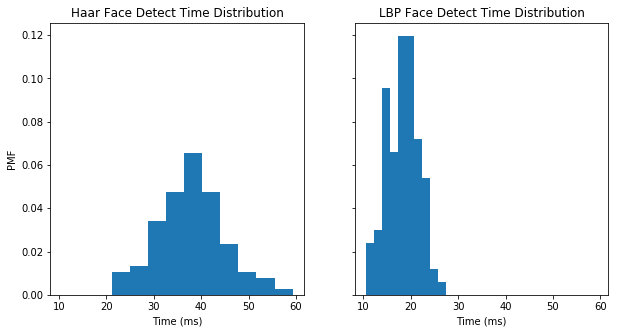

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
_ = axs[0].set_xlabel('Time (ms)')
_ = axs[1].set_xlabel('Time (ms)')
_ = axs[0].set_ylabel('PMF')

bins = int(np.sqrt(len(haar_bs_replicate_list)))
_ = axs[0].hist(haar_bs_replicate_list, bins=bins, density=True)
_ = axs[0].set_title('Haar Face Detect Time Distribution')

bins = int(np.sqrt(len(lbp_bs_replicate_list)))
_ = axs[1].hist(lbp_bs_replicate_list, bins=bins, density=True)
_ = axs[1].set_title('LBP Face Detect Time Distribution')

plt.show()

Looking at the distribution of average detection times for both classifiers, we can make some initial observations. First is that the average runtime for the Haar classifier is around 40 ms compared to the average runtime of around 20 ms for the LBP classifier. In addition, the variance in runtime between the Haar classifier and the LBP classifier is higher too. The spread of average runtimes for the Haar classifier is around 20 ms vs. the spread of average runtimes for the LBP classifier being around 7.5 ms. This suggests that the LBP classifier is more consistently classifying images at around its mean runtime than the Haar classifier.

---

## Difference of Two Means Hypothesis Test

All signs indicate that the Haar classifier is slower and less consistent than the LBP classifier. In order to empirically state that this belief is true, we can perform a Null Hypothesis Test for the difference of two means. For our Null Hypothesis, we are going to assume that there is no difference between the Haar and LBP classifier classification times. For our Alternative Hypothesis, we are going to state that there is a measurable difference between the two classifier's average detection times. If $\alpha < 0.05$ for this test, then we will reject the Null Hypothesis in favor of the alternative.

The combination of our two variables is defined as such

$$
\overline{x}_{diff} = \overline{x}_{haar} - \overline{x}_{lbp}
$$

$$
\sigma_{haar} = \frac{s_{haar}}{\sqrt{n}}
$$

$$
\sigma_{lbp} = \frac{s_{lbp}}{\sqrt{n}}
$$

$$
\sigma_{diff} = \sqrt{\sigma^{2}_{haar} + \sigma^{2}_{lbp}}
$$

In [14]:
haar_mean = np.mean(haar_bs_replicate_list)
haar_std = np.std(haar_bs_replicate_list) / np.sqrt(len(haar_bs_replicate_list))

lbp_mean = np.mean(lbp_bs_replicate_list)
lbp_std = np.std(lbp_bs_replicate_list) / np.sqrt(len(lbp_bs_replicate_list))

mean_diff = haar_mean - lbp_mean
std_diff = np.sqrt(haar_std**2 + lbp_std**2)

Now that we've defined the difference in means and standard deviation between average Haar and LBP runtimes, we can now run the Null Hypothesis Test.

The Null Hypothesis is that there is no difference between the two runtimes; $\mu_{0} = 0$. With our $\mu_{0}$ defined, we'll create a normal distribution of 10000 points centered around $\mu_{0}$ spread by the joint standard deviation between the Haar and LBP average classification times. The intervals are defined at the 2.5 and 97.5 percentile marks. This means that 5% of our data lies outside these intervals which is consistent with our $\alpha=0.05$ assumption.

If our observed difference between two means lies within the 95% interval of our distribution centered around $\mu_{0}$, then we fail to reject the Null Hypothesis. If our observed difference lies outside the 95% interval, then we will reject the Null in favor of the Alternative. The results are shown below.

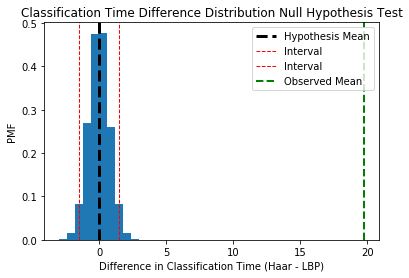

mu_not = 0 ms
lower interval = -1.49 ms
upper interval = 1.50 ms
observed difference = 19.73 ms
observed z-score = 26.01


In [15]:
np.random.seed(42)

mu_not = 0
z_obs = (mean_diff - mu_not) / std_diff
samples = np.random.normal(mu_not, std_diff, 10000)
intervals = np.percentile(samples, [2.5, 97.5])

# Plot the generated points as a histogram with markers indicating confidence interval, mean, and observation
_ = plt.hist(samples, bins=bins, density=True)
_ = plt.axvline(mu_not, color='black', linestyle='dashed', linewidth=3)
_ = plt.axvline(intervals[0], color='red', linestyle='dashed', linewidth=1)
_ = plt.axvline(intervals[1], color='red', linestyle='dashed', linewidth=1)
_ = plt.axvline(mean_diff, color='green', linestyle='dashed', linewidth=2)

# Display the distribution
_ = plt.title('Classification Time Difference Distribution Null Hypothesis Test')
_ = plt.xlabel('Difference in Classification Time (Haar - LBP)')
_ = plt.ylabel('PMF')
_ = plt.legend(('Hypothesis Mean', 'Interval', 'Interval', 'Observed Mean'), loc='upper right')
plt.show()

# Print summary statistics
print('mu_not = {} ms'.format(mu_not))
print('lower interval = {:.2f} ms'.format(intervals[0]))
print('upper interval = {:.2f} ms'.format(intervals[1]))
print('observed difference = {:.2f} ms'.format(mean_diff))
print('observed z-score = {:.2f}'.format(z_obs))

Assuming that our Null Hypothesis is true, then we should expect the average difference in runtimes between the Haar and LBP classifier to be around $\pm1.50$ ms. Our observations, however, aren't consistent with this assumption. The observed difference from our distribution is 19.73 ms which is 26.01 standard deviations away from the mean. There is an extremely low probability that we observe the difference in timing that we observed between the Haar and LBP average runtimes from the sample of pictures we gathered from <i>The Office</i>. <b><i>As such, we'll reject the Null Hypothesis in favor for the alternative that there is a measurable difference in average runtimes between the two classifiers.</i></b>

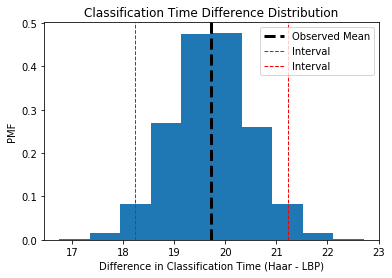

lower interval = 18.2 ms
upper interval = 21.2 ms
observed difference = 19.73 ms


In [16]:
np.random.seed(42)

samples = np.random.normal(mean_diff, std_diff, 10000)
intervals = np.percentile(samples, [2.5, 97.5])

# Plot the generated points as a histogram with markers indicating confidence interval, mean, and observation
_ = plt.hist(samples, bins=bins, density=True)
_ = plt.axvline(mean_diff, color='black', linestyle='dashed', linewidth=3)
_ = plt.axvline(intervals[0], color='red', linestyle='dashed', linewidth=1)
_ = plt.axvline(intervals[1], color='red', linestyle='dashed', linewidth=1)

# Display the distribution
_ = plt.title('Classification Time Difference Distribution')
_ = plt.xlabel('Difference in Classification Time (Haar - LBP)')
_ = plt.ylabel('PMF')
_ = plt.legend(('Observed Mean', 'Interval', 'Interval'), loc='upper right')
plt.show()

# Print summary statistics
print('lower interval = {:.1f} ms'.format(intervals[0]))
print('upper interval = {:.1f} ms'.format(intervals[1]))
print('observed difference = {:.2f} ms'.format(mean_diff))

With the combined average difference between the Haar and LBP classifiers, we conclude that the Haar classifier is 19.73 ms slower on average versus the LBP classifier, give or take 1.5 ms. <b><i>We will use the LBP classifier for facial detection moving forward.</i></b>

Formalizing our thought process and performing a Null Hypothesis Test on the average runtimes between the two classifiers allowed us to make a decision on which classifier we'll want to work with moving forward. When making data science decisions, it's important to know what tools you have at your disposal and make empirical decisions based on what's available. We're moving forward with the LBP classifier since it'll save us a lot of time as we're iterating through facial recognition design. 

On the next post, we're diving head first into facial recognition. We'll put the computer to the test in identifying characters from <i>The Office</i> which will move us one step closer to finding the amount of screentime each character on the show had for the first season. Until then, cheers!